# Homework 8

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
#given inputs
temp = 298 #kelvin
pres = 1e5 #Pascals
Rgas = 8.314 #J/(mol-K)
avo = 6.022e23 

nox = 30 #ppbv
rh = 100 #ppbv 
PHOx = 0.1 #pptv/s

In [3]:
#rate constants, units are cm3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 # units s-1
k8 = 1.9e-14

In [4]:
#unit conversions
airden = (pres*avo) / (Rgas*temp*1e6) #molec/cm3
Cnox = nox*1e-9*airden
Crh = rh*1e-9*airden
CPHOx = PHOx*1e-12*airden  #molec/(cm3-s)
ppbfac = 1e9/airden

# u[0] u[1] u[2] u[3] u[4] u[5] u[6]
# NO   NO2   OH  RO2  HO2   O3   RH
def myfun(t,u):
    f = np.zeros(7)
    f[0] = -k2*u[3]*u[0] + k7*u[1] - k8*u[5]*u[0] - k3*u[4]*u[0]
    f[1] = k2*u[3]*u[0] + k3*u[4]*u[0] + k8*u[5]*u[0] - k7*u[1] - k4*u[2]*u[1]
    f[2] = -k1*u[6]*u[2] + k3*u[4]*u[0] - k4*u[2]*u[1] + CPHOx 
    f[3] = k1*u[6]*u[2] - k2*u[3]*u[0] - k6*u[3]*u[4]
    f[4] = k2*u[3]*u[0] - k3*u[4]*u[0] - 2*k5*u[4]**2 - k6*u[3]*u[4]
    f[5] = k7*u[1] - k8*u[5]*u[0]
    f[6] = -k1*u[6]*u[2]
    return f
    

In [5]:
#initial conditions
# NOx = NO + NO2
u0 = np.zeros(7)
u0[0] = Cnox*(2/3)
u0[1] = Cnox*(1/3)
u0[2] = 0
u0[3] = 0
u0[4] = 0
u0[5] = 0
u0[6] = Crh   #molec / cm3 of RH hydrocarbon

In [6]:
#timestep
Dt = 2 #seconds
t0 = 0
tmax = 96*3600
t = np.arange(t0, t0+tmax, Dt)
NN = np.shape(t)
N = NN[0]

In [7]:
sol = solve_ivp(myfun, [t0,tmax], u0, method='LSODA', t_eval=t)

In [37]:
def oz_max(nox, rh):
    Cnox = nox*1e-9*airden
    Crh = rh*1e-9*airden
    u0[0] = Cnox*(2/3)
    u0[1] = Cnox*(1/3)
    u0[6] = Crh   #molec / cm3 of RH hydrocarbon
    sol = solve_ivp(myfun, [t0,tmax], u0, method='LSODA', t_eval=t)
    maxO3 = np.max(sol.y[5]*ppbfac)
    return maxO3

In [38]:
#You can use a range of 0-50 ppb for initial NOx and 50-500 ppb for initial RH (hydrocarbon)
n = 10
NOx0 = 0
NOx_max = 50
NOx = np.linspace(NOx0, NOx_max, n)

rh0 = 50
rh_max = 500
rh = np.linspace(rh0, rh_max, n)

In [39]:
#create a meshgrid and solve at each position
xx,yy = np.meshgrid(NOx, rh)
O3 = np.zeros_like(xx) 
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        O3[i, j] = oz_max(xx[i, j], yy[i, j])

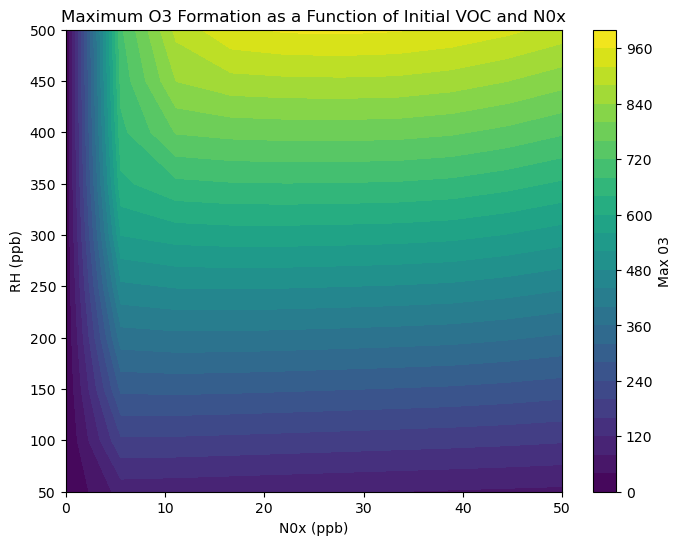

In [40]:
#Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, O3, levels=30)  # Filled contours
plt.colorbar(contour, label='Max 03')
plt.xlabel('N0x (ppb)')
plt.ylabel('RH (ppb)')
plt.title('Maximum O3 Formation as a Function of Initial VOC and N0x')
plt.show()

The plot roughly follows what was shown in the last slide on courseworks. The levels may be off due to using different ranges of values and RH instead of VOC. Overall though the model looks to accomplish what we want it to